In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import scipy.stats as stats

In [2]:
# load train data
train = pd.read_csv('microarray_train.csv', index_col=0)

# save indexes of ALL and AML samples
allidx = train[train['cancer']=='ALL'].index
#print(allidx)
amlidx = train[train['cancer']=='AML'].index
#print(amlidx)

# seprate target from features
target = train.pop('cancer')
print(train.shape)
train.head()

(38, 7129)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [3]:
# label encode target, ALL:0, AML:1
le = LabelEncoder()
target = le.fit_transform(target)
print(le.classes_)
target

['ALL' 'AML']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [4]:
# negative values relaced with 0
train = train.mask(train < 0, 0)
train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,0,0,88,0,0,199,0,252,206,...,185,511,0,389,0,793,329,36,191,0
1,0,0,0,283,0,0,0,0,101,74,...,169,837,0,442,0,782,295,11,76,0
2,0,0,0,309,0,0,33,0,206,0,...,315,1199,33,168,52,1138,777,41,228,0
3,0,0,265,12,0,0,158,0,49,31,...,240,835,218,174,0,627,170,0,126,0
4,0,0,0,168,0,0,4,0,70,252,...,156,649,57,504,0,250,314,14,56,0


In [5]:
# check if features with all zero values
zeros = (train==0).sum(axis=0)
allzeros = (zeros == len(train.index))
print('num features all zero:', allzeros.sum())

zerocols = list(allzeros[allzeros==True].index)
train = train.drop(columns=zerocols)
# log base 2 transformed, add 1 due to zero values
train = np.log2(train + 1)
train.isna().sum().sum()
train.head()

num features all zero: 396


,AFFX-BioB-5_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,0.000000,6.475733,7.643856,7.982994,7.693487,0.000000,6.247928,8.577429,0.000000,...,7.539159,9.000000,0.000000,8.607330,0.00000,9.632995,8.366322,5.209453,7.584963,0.0
1,0.0,0.000000,8.149747,0.000000,6.672425,6.228819,4.321928,7.515700,7.366322,0.000000,...,7.409391,9.710806,0.000000,8.791163,0.00000,9.612868,8.209453,3.584963,6.266787,0.0
2,0.0,0.000000,8.276124,5.087463,7.693487,0.000000,4.321928,7.707359,8.758223,6.409391,...,8.303781,10.228819,5.087463,7.400879,5.72792,10.153552,9.603626,5.392317,7.839204,0.0
3,0.0,8.055282,3.700440,7.312883,5.643856,5.000000,8.507795,7.159871,8.087463,0.000000,...,7.912889,9.707359,7.774787,7.451211,0.00000,9.294621,7.417853,0.000000,6.988685,0.0
4,0.0,0.000000,7.400879,2.321928,6.149747,7.982994,7.285402,5.044394,7.741467,1.000000,...,7.294621,9.344296,5.857981,8.980140,0.00000,7.971544,8.299208,3.906891,5.832890,0.0


(array([ 503.,  301.,  275.,  208.,  283.,  293.,  252.,  411.,  617.,
        3590.]),
 array([0.02631579, 0.12368421, 0.22105263, 0.31842105, 0.41578947,
        0.51315789, 0.61052632, 0.70789474, 0.80526316, 0.90263158,
        1.        ]),
 <BarContainer object of 10 artists>)

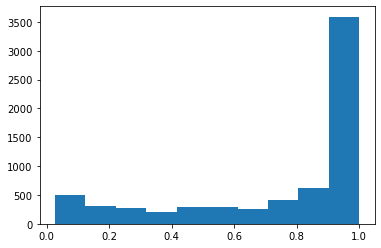

In [6]:
# create dataframe of metrics
metrics = pd.DataFrame(index=train.columns)

# compute percent positive intensity values for each feature
metrics['pctvalpos'] = [sum(train[col]>0)/len(train[col]) for col in train.columns]
plt.hist(metrics['pctvalpos'])

In [7]:
# compute mutual information scores
metrics['mi'] = mutual_info_classif(train, target, random_state=123)
metrics.describe()

,pctvalpos,mi
count,6733.000000,6733.000000
mean,0.754293,0.052042
std,0.318594,0.072487
min,0.026316,0.000000
25%,0.552632,0.000000
50%,0.947368,0.018912
75%,1.000000,0.082276
max,1.000000,0.566292


In [8]:
# compute regular p-values for each feature between ALL and AML 
pval=[]
for col in range(len(train.columns)):
    pval.append(stats.ttest_ind(train.iloc[amlidx,col], train.iloc[allidx,col], equal_var=False)[1]) # store p-val
metrics['pval'] = pval    

# compute p-values with stats for each feature between ALL and AML 
#pval2 = []
#for col in range(len(train.columns)):
#    m1 = train.iloc[allidx,col].mean()
#    sd1 = np.std(train.iloc[allidx,col])
#    m2 = train.iloc[amlidx,col].mean()
#    sd2 = np.std(train.iloc[amlidx,col])
#    pval2.append(stats.ttest_ind_from_stats(mean1=m1, std1=sd1, nobs1=len(allidx),\
#                                            mean2=m2, std2=sd2, nobs2=len(amlidx), equal_var=False)[1])
#metrics['pval2'] = pval2


In [9]:
# compute adjusted p-values for each feature between ALL and AML with permutations 
pval=[]
for col in range(len(train.columns)):
    pval.append(stats.ttest_ind(train.iloc[amlidx,col], train.iloc[allidx,col], \
                                permutations=5000, random_state=123,equal_var=False)[1]) # store p-val
metrics['adj_pval'] = pval    


In [10]:
metrics.describe()

,pctvalpos,mi,pval,adj_pval
count,6733.000000,6733.000000,6.733000e+03,6733.000000
mean,0.754293,0.052042,3.619464e-01,0.389671
std,0.318594,0.072487,3.084091e-01,0.321626
min,0.026316,0.000000,2.061858e-10,0.000000
25%,0.552632,0.000000,6.915102e-02,0.077800
50%,0.947368,0.018912,3.031255e-01,0.334400
75%,1.000000,0.082276,6.208379e-01,0.665400
max,1.000000,0.566292,9.999199e-01,1.000000


In [11]:
metrics

,pctvalpos,mi,pval,adj_pval
AFFX-BioB-5_at,0.105263,0.000000,0.423179,0.4274
AFFX-BioB-3_at,0.342105,0.000000,0.842672,0.8294
AFFX-BioC-5_at,0.921053,0.164796,0.002735,0.0036
AFFX-BioDn-3_at,0.421053,0.000000,0.401665,0.3880
AFFX-CreX-3_at,0.894737,0.000000,0.986164,0.9866
...,...,...,...,...
X83863_at,1.000000,0.000000,0.088929,0.0942
Z17240_at,1.000000,0.000000,0.834202,0.8382
L49218_f_at,0.789474,0.076108,0.141204,0.1392
M71243_f_at,0.973684,0.175035,0.001413,0.0008


<AxesSubplot:xlabel='adj_pval', ylabel='Count'>

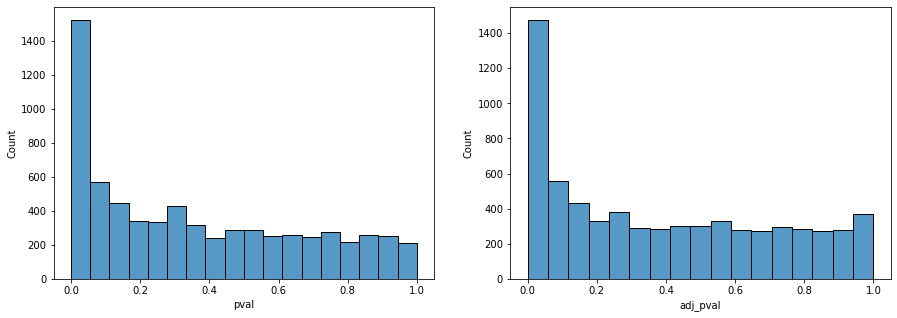

In [12]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.histplot(x='pval', data=metrics, ax=axs[0])
sns.histplot(x='adj_pval', data=metrics, ax=axs[1])

In [13]:
# estimate percent truly null features
# p-value distribution looks flat starting ~0.5
L = 0.5
nullp = metrics.loc[metrics['adj_pval']>L,'adj_pval'].sum() / (len(metrics)*(1-L))
nullp

0.5665697311748106

In [14]:
# false discovery rate at threshold t
t = 0.001
# number p-values below threshold
sigp = (metrics['adj_pval']<=t).sum()
# calculate FDR
(nullp*len(metrics)*t) / sigp

0.013064089041095888

In [15]:
metrics[metrics['adj_pval']<=0.001].describe()

,pctvalpos,mi,pval,adj_pval
count,292.000000,292.000000,2.920000e+02,292.000000
mean,0.904380,0.234067,5.890563e-04,0.000273
std,0.170642,0.093166,1.137271e-03,0.000317
min,0.184211,0.056921,2.061858e-10,0.000000
25%,0.894737,0.163534,1.764495e-05,0.000000
50%,1.000000,0.222067,1.599239e-04,0.000200
75%,1.000000,0.294864,6.979777e-04,0.000400
max,1.000000,0.566292,1.061454e-02,0.001000


In [16]:
metrics[metrics['adj_pval']<=0.001].index

Index(['AFFX-HUMTFRR/M11507_5_at', 'AFFX-HUMTFRR/M11507_M_at',
       'AFFX-HUMTFRR/M11507_3_at', 'AB002559_at', 'AF009426_at', 'D00763_at',
       'D10495_at', 'D14658_at', 'D14664_at', 'D14811_at',
       ...
       'M31523_at', 'M99438_at', 'U27460_at', 'X16546_at', 'Z30644_at',
       'M15395_at', 'M28170_at', 'X07730_at', 'U29175_at', 'M71243_f_at'],
      dtype='object', length=292)

In [17]:
metrics[metrics['mi']>=0.15].describe()

,pctvalpos,mi,pval,adj_pval
count,686.000000,686.000000,6.860000e+02,686.000000
mean,0.841223,0.219392,1.072921e-01,0.120338
std,0.246327,0.066601,2.135449e-01,0.240900
min,0.026316,0.150100,2.061858e-10,0.000000
25%,0.789474,0.170531,3.750322e-04,0.000400
50%,0.973684,0.199749,6.000031e-03,0.006700
75%,1.000000,0.244846,8.922397e-02,0.097750
max,1.000000,0.566292,9.945371e-01,1.000000


In [18]:
metrics[metrics['mi']>=0.15].index

Index(['AFFX-BioC-5_at', 'AFFX-ThrX-5_at', 'AFFX-HUMRGE/M10098_5_at',
       'AFFX-HUMTFRR/M11507_5_at', 'AFFX-HUMTFRR/M11507_M_at',
       'AFFX-HUMTFRR/M11507_3_at', 'AB000114_at', 'AF000231_at', 'AF005037_at',
       'AF009426_at',
       ...
       'M62303_at', 'U20499_at', 'X07496_at', 'Z68193_at', 'D38437_f_at',
       'V01516_f_at', 'L10717_at', 'L34355_at', 'U29175_at', 'M71243_f_at'],
      dtype='object', length=686)

<AxesSubplot:>

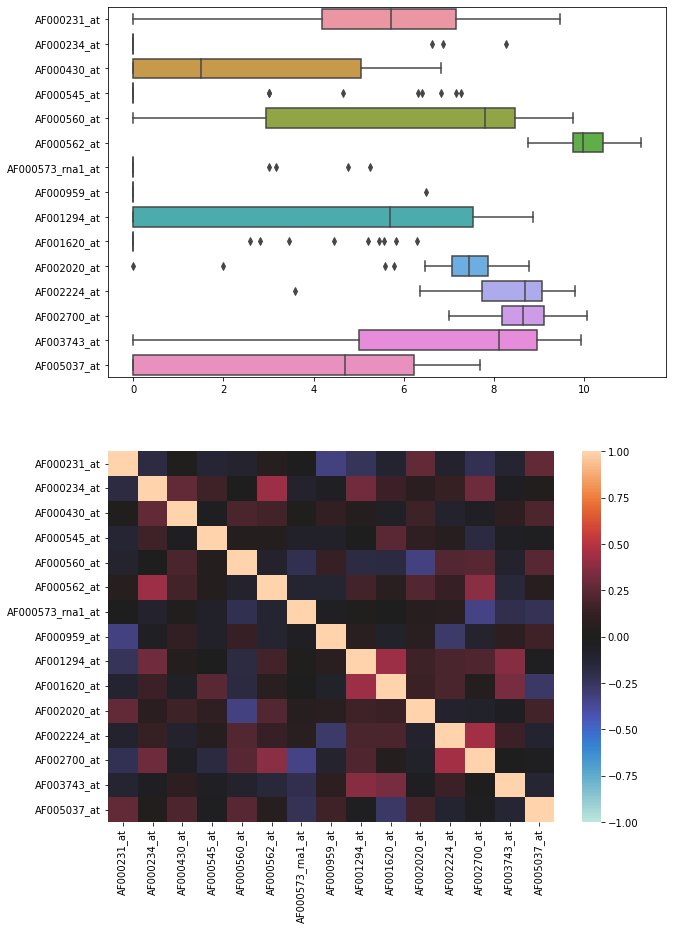

In [19]:
# quick look at 15 features
fig, ax = plt.subplots(2,1,figsize=(10,15))
sns.boxplot(data=train[train.columns[100:115]], orient='h', ax=ax[0])
corrmat = train[train.columns[100:115]].corr()
sns.heatmap(corrmat, vmin=-1,vmax=1, center=0, ax=ax[1])

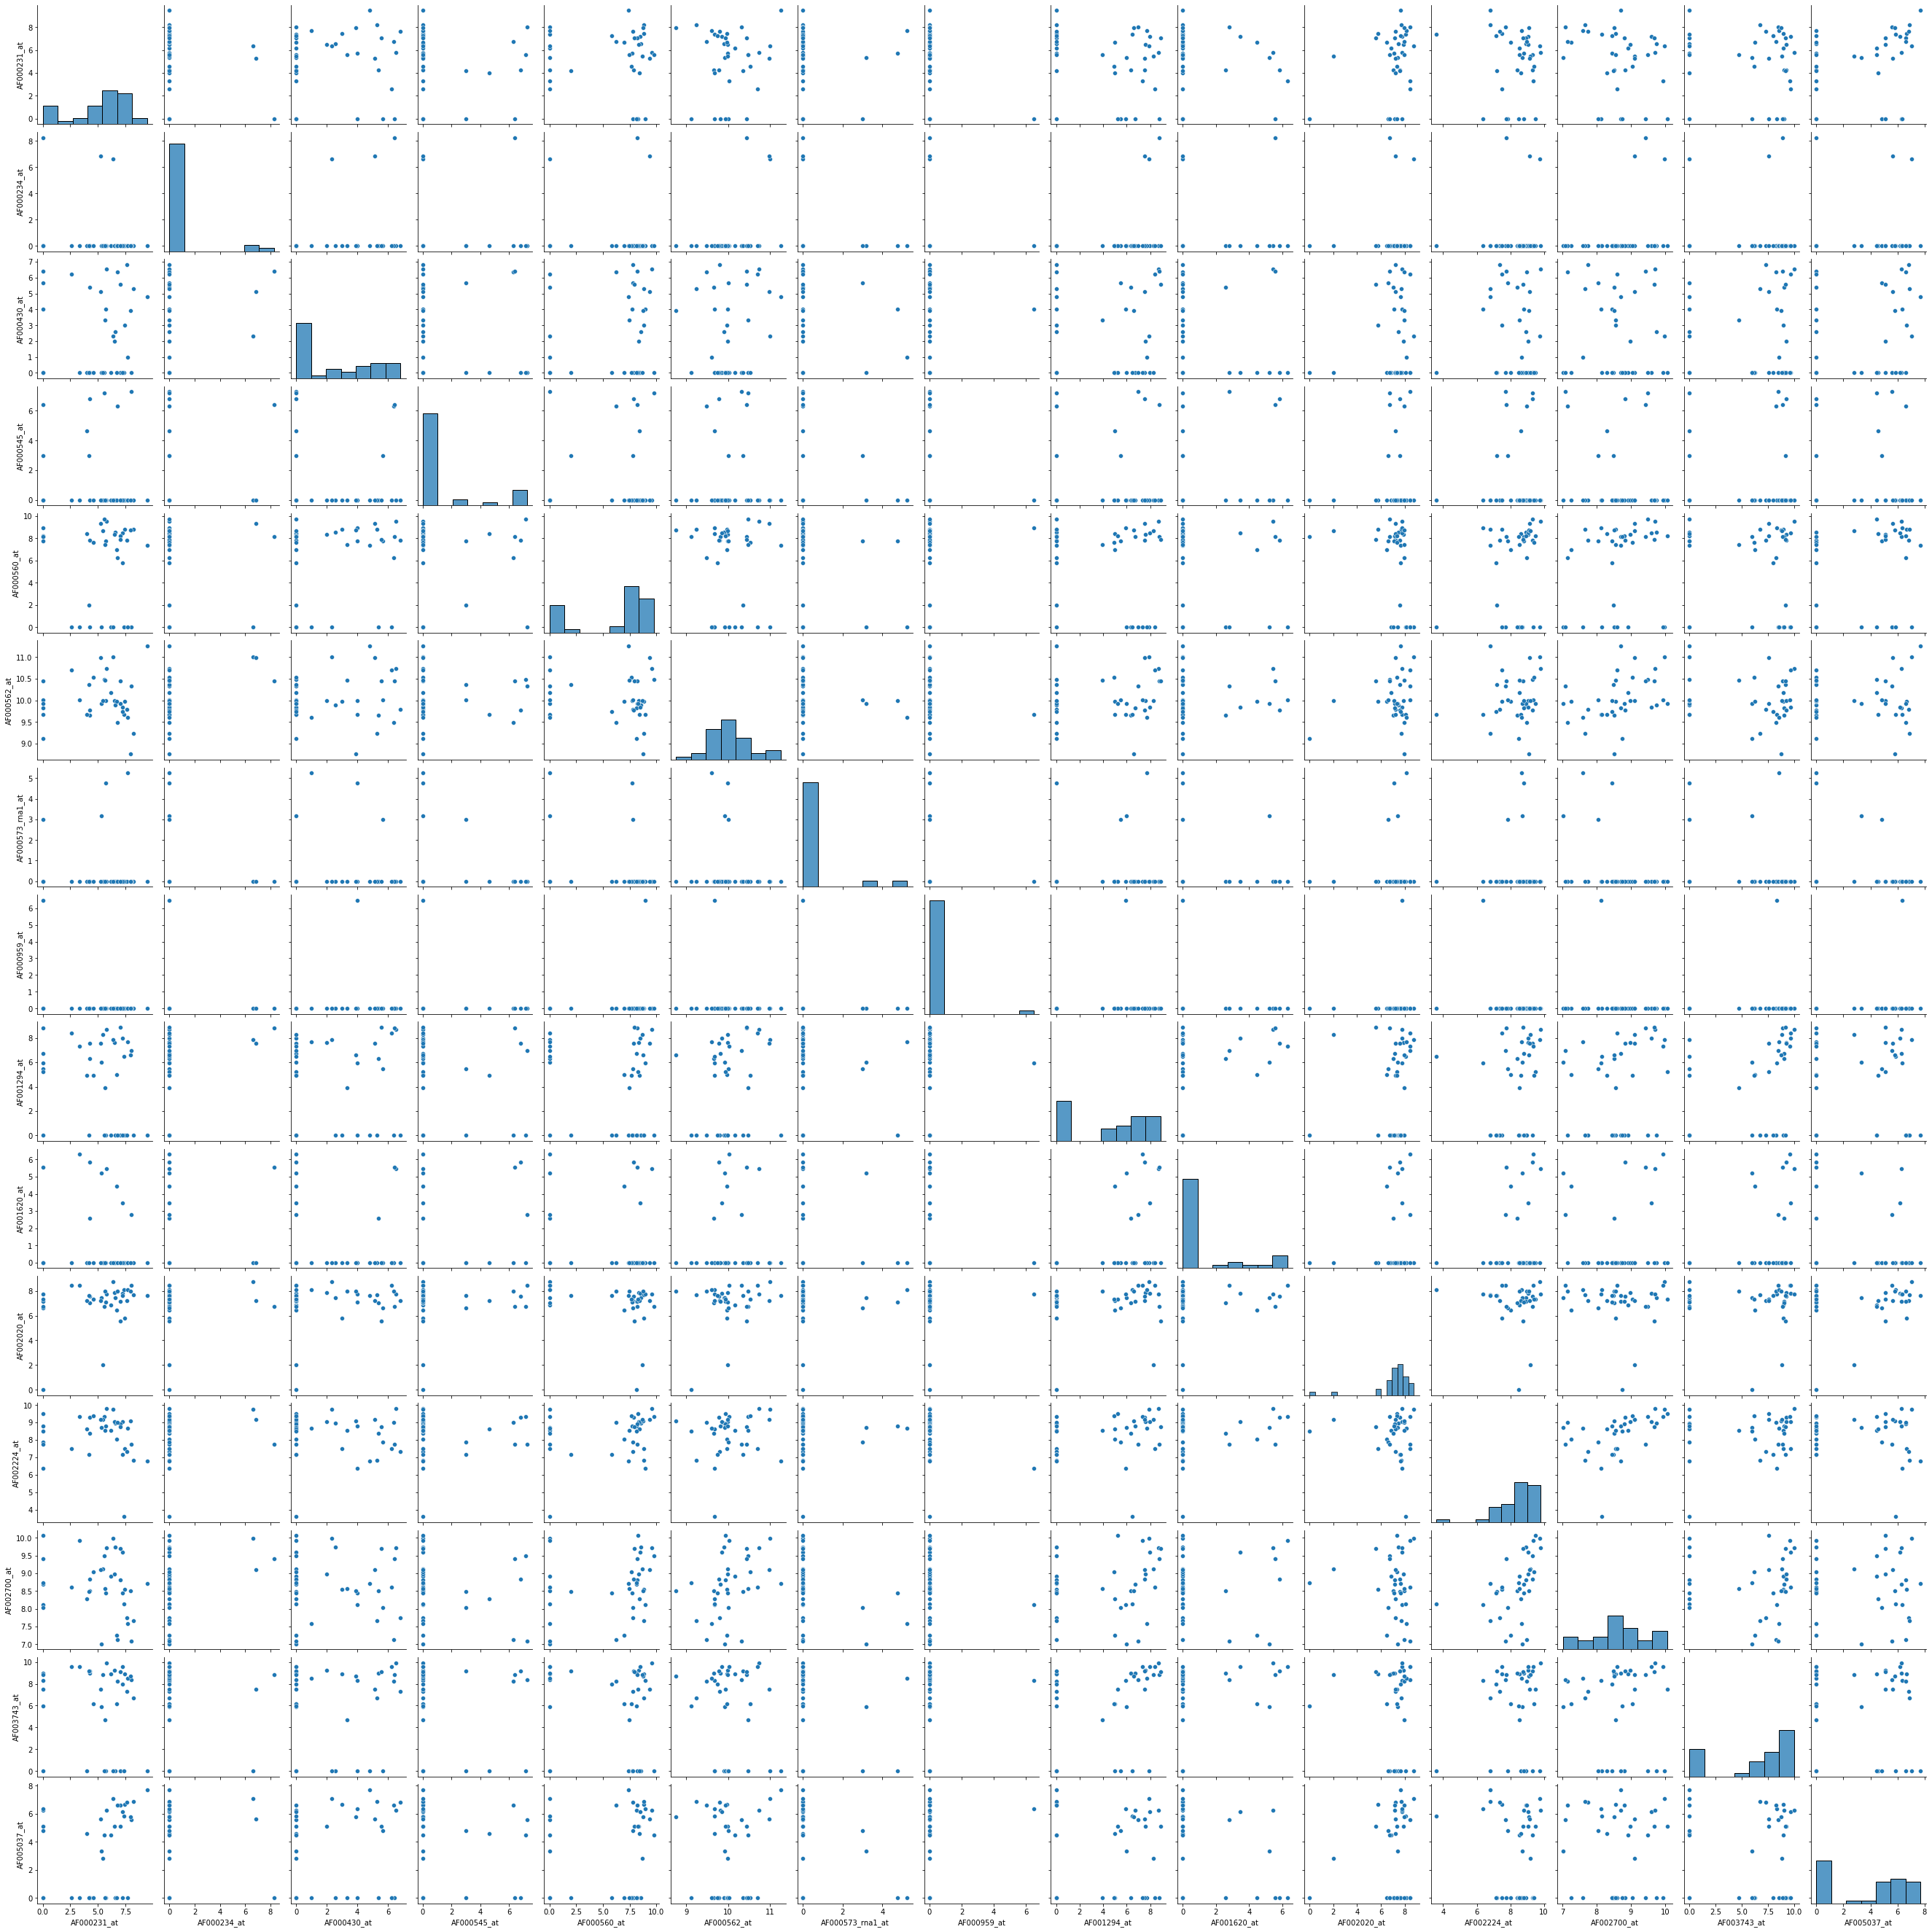

In [20]:
sns.pairplot(data=train[train.columns[100:115]])